# All about features
The features I found useful while trading
- PSAR
- MACD
- KDJ
- GMMA
- Bollinger

functions:
https://ta-lib.github.io/ta-lib-python/funcs.html

github page:
https://github.com/ta-lib/ta-lib-python

In [50]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import seaborn as sns 

import talib


In [51]:
def get_plotly(df, ticker):
    fig = make_subplots(
        rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1, row_heights=[0.7, 0.3]
    )

    fig.add_trace(
        go.Candlestick(
            x=df.index,
            open=df["Open"],
            high=df["High"],
            low=df["Low"],
            close=df["Close"],
        ),
        row=1,
        col=1,
    )

    fig.update_layout(
        title=f"{ticker} price",
        xaxis_title="Date",
        yaxis_title="Price",
        autosize=True,
        # showlegend=True,
        xaxis_rangeslider_visible=False,
        margin=dict(l=0, r=10, t=50, b=50),
    )
    return fig

def plotly_add_bar(fig, df, feature):
    fig.add_trace(
        go.Bar(
            x=df.index,
            y=df[feature],
            name=feature,
        ),
        row=2,
        col=1,
    )
    return fig

def plotly_add_line(fig, df, feature):
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[feature],
            mode="lines",
            name=feature,
        ),
        row=2,
        col=1,
    )
    return fig

def plotly_add_ma(fig, df, feature):
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[feature],
            mode="lines",
            name=feature,
        ),
        row=1,
        col=1,
    )
    return fig

In [52]:
ticker = "NFLX"
df = yf.download(ticker, period="6mo", interval="1d", progress=False)
df = df.drop(columns="Adj Close")
open, high, low, close = df["Open"], df["High"], df["Low"], df["Close"]


# PSAR

In [53]:
df["psar"] = talib.SAR(df["High"], df["Low"], acceleration=0.02, maximum=0.2)


In [54]:
fig = get_plotly(df, ticker)
fig = plotly_add_ma(fig, df, "psar")
fig.show()

# MACD

In [55]:
df["macd"], df["macd_signal"], df["macd_hist"] = talib.MACDFIX(df["Close"], signalperiod=9)


In [56]:
fig = get_plotly(df, ticker)
fig = plotly_add_bar(fig, df, "macd_hist")
fig = plotly_add_line(fig, df, "macd_signal")
fig = plotly_add_line(fig, df, "macd")
fig.show()


# KDJ

In [57]:
# Calculate RSV
c = df["Close"]
h = df["High"].rolling(window=9).max()
l = df["Low"].rolling(window=9).min()

# raw stochastic value, how close to past min max
rsv = (100 * ((c - l) / (h - l))).fillna(50)

def kd_smoothing(factor):
    smoothing = []
    prev = 50
    for i in factor:
        curr = (2 / 3) * prev + (1 / 3) * i
        smoothing.append(curr)
        prev = curr
    return smoothing

# Calculate K, D, and J
df["K"] = kd_smoothing(rsv)
df["D"] = kd_smoothing(df["K"])
df["J"] = 3 * df["K"] - 2 * df["D"]

In [58]:
fig = get_plotly(df, ticker)
fig = plotly_add_line(fig, df, "K")
fig = plotly_add_line(fig, df, "D")
fig = plotly_add_line(fig, df, "J")
fig.show()

# GMMA

In [59]:
gmma_ema = [3, 5, 8, 10, 12, 35, 40, 45, 50, 60]
for i in gmma_ema: 
    df[f"{i}ema"] = df["Close"].ewm(span=i).mean()

In [60]:
fig = get_plotly(df, ticker)
for i in gmma_ema: 
    fig = plotly_add_ma(fig, df, f"{i}ema")
fig.show()

# Bollinger

In [61]:
df["bb_up"], _, df["bb_low"] = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df["bb_wid"] = (df["bb_up"] - df["bb_low"]) / df["Close"]

In [62]:
fig = get_plotly(df, ticker)
fig = plotly_add_ma(fig, df, "bb_up")
fig = plotly_add_ma(fig, df, "bb_low")
fig = plotly_add_bar(fig, df, "bb_wid")

fig.show()

# Normalizing data & making data meaningful
To send meaningful data to any model, the data should be normalized, especially stock data as similar patterns could appear in very different prices

1. Making the data meaningful
   - converting price-related data
     - open, high, low, ma, psar -> compare to close
     - close -> compare to prev close
   - volume -> compare to 20d moving average
2. Normalizing (StandardScaler)
   - scale the data to similar ranges

In [63]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

## price related

In [64]:
price_related_col = ['Open', 'High', 'Low', 'psar', 'bb_up', 'bb_low']
gmma_col = [f"{i}ema" for i in gmma_ema]

price_related_col += gmma_col

In [65]:
remaining_col = set(df.columns) - set(price_related_col)
print(remaining_col)

{'Volume', 'macd_hist', 'bb_wid', 'J', 'D', 'Close', 'macd_signal', 'K', 'macd'}


In [66]:
df[price_related_col] = df[price_related_col].div(df["Close"], axis=0)

In [67]:
df["Close"] = df["Close"].pct_change()

## volume

In [68]:
df["Volume"] = df["Volume"] / df["Volume"].rolling(window=20).mean()

## normalizing

In [70]:
df[df.columns] = StandardScaler().fit_transform(df)


C:\Users\edton\AppData\Local\Temp\ipykernel_144264\4138051965.py:5: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



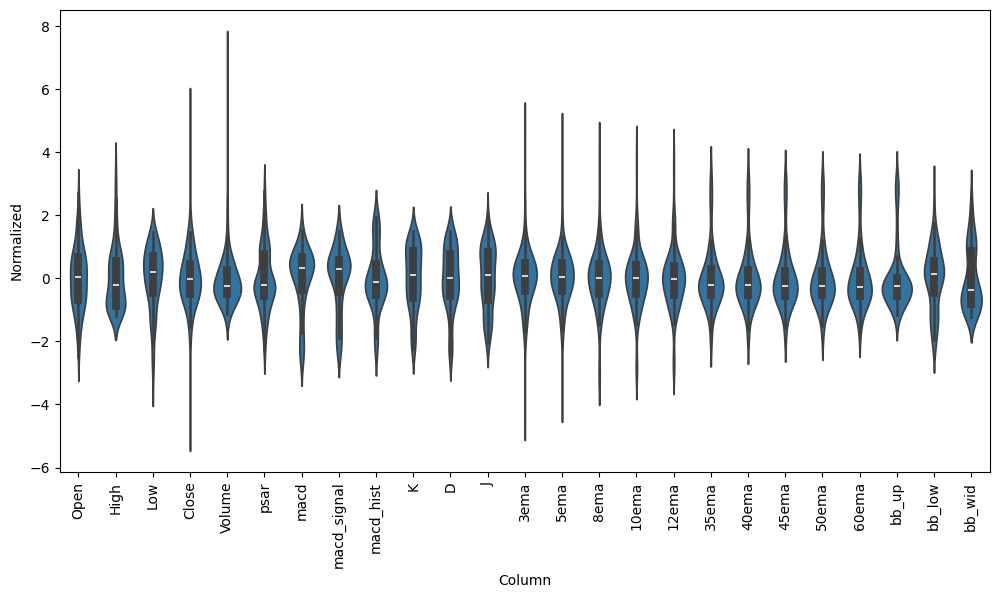

In [72]:
df_violin = df.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_violin)
_ = ax.set_xticklabels(df.keys(), rotation=90)